In [ ]:
import cv2
import numpy as np
from scipy.ndimage.filters import convolve
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import time
from tqdm import trange

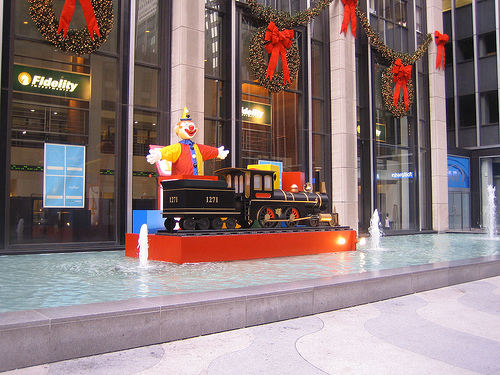

In [ ]:
img = cv2.imread('/content/christmas_original.png')
cv2_imshow(img)

In [ ]:
img.shape

(375, 500, 3)

In [ ]:
img[0][0]

array([198, 196, 216], dtype=uint8)

# Backward seam carving

In [ ]:
def calculate_energy(img):

  # Sobel gradient
  kernel = np.array([[1, 2, 1],
                       [0, 0, 0,],
                       [-1, -2, -1]])
  
  kernel_y = np.stack([kernel] * 3, axis=2)

  kernel  = np.array([
                      [1, 0, -1],
                      [2, 0, -2],
                      [1, 0, -1]
                    ])
  
  kernel_x = np.stack([kernel] * 3, axis = 2)

  img = img.astype('float32')
  convolved = np.absolute(convolve(img, kernel_y)) + np.absolute(convolve(img, kernel_x))
  energy_img = convolved.sum(axis=2)

  return energy_img

In [ ]:
def minimum_seam(img):
    r, c, _ = img.shape
    energy_map = calculate_energy(img)

    M = energy_map.copy()
    backtrack = np.zeros_like(M, dtype=np.int)

    for i in range(1, r):
        for j in range(0, c):
            # Handle the left edge of the image, to ensure we don't index -1
            if j == 0:
                idx = np.argmin(M[i - 1, j:j + 2])
                backtrack[i, j] = idx + j
                min_energy = M[i - 1, idx + j]
            else:
                idx = np.argmin(M[i - 1, j - 1:j + 2])
                backtrack[i, j] = idx + j - 1
                min_energy = M[i - 1, idx + j - 1]

            M[i, j] += min_energy

    return M, backtrack

# Iterate crop image

In [ ]:
def carve_column(img, shape, t):
    img_line = np.zeros(shape).astype(int)
    r, c, _ = img.shape
    img2 = img.copy()
    img_line[0:r, 0:c] = img2
    img_line = img_line.astype(np.uint8)
    if t == 'bw':
      M, backtrack = minimum_seam(img2)
    else:
      M, backtrack = cal_seam_forward(img2)

    # Create a (r, c) matrix filled with the value True
    # We'll be removing all pixels from the image which
    # have False later
    mask = np.ones((r, c), dtype=np.bool)

    # Find the position of the smallest element in the
    # last row of M
    seam_index = []
    j = np.argmin(M[-1])
    for i in range(r-1, -1, -1):
        # Mark the pixels for deletion
        k = j
        mask[i, j] = False     
        seam_index.append(j)   
        j = backtrack[i, j]    
        if i>= 1:
          cv2.line(img_line, (k, i), (j, i-1), [0, 255, 0], 2)

    # Since the image has 3 channels, we convert our
    # mask to 3D
    mask = np.stack([mask] * 3, axis=2)
    # cv2_imshow(img_line)
    # Delete all the pixels marked False in the mask,
    # and resize it to the new image dimensions
    img = img[mask].reshape((r, c - 1, 3))
    seam_index.reverse()
    return img, img_line, seam_index

In [ ]:
def crop_c(img, scale_c, t):
    r, c, _ = img.shape
    img2 = img.copy()
    new_c = int(scale_c * c)
    img_arr = []
    img_arr.append(img2)
    for i in trange(c - new_c): # use range if you don't want to use tqdm
        img2, img_line, _ = carve_column(img2, img.shape, t)
        new_h, new_c, _ = img2.shape
        canvas = np.zeros(img.shape).astype(int)
        canvas[0:new_h, 0:new_c] = img2
        canvas = canvas.astype(np.uint8)
        img_arr.append(img_line)
        img_arr.append(canvas)
    return img2, img_arr

In [ ]:
def crop_r(img, scale_r):
    img = np.rot90(img, 1, (0, 1))
    img, img_arr = crop_c(img, scale_r, 'bw')
    img = np.rot90(img, 3, (0, 1))
    return img, img_arr

# Add seams

In [ ]:
def add_seam(im, seam_idx):
    h, w = im.shape[:2]
    output = np.zeros((h, w + 1, 3))
    for row in range(h):
        col = seam_idx[row]
        for ch in range(3):
            if col == 0:
                p = np.average(im[row, col: col + 2, ch])
                output[row, col, ch] = im[row, col, ch]
                output[row, col + 1, ch] = p
                output[row, col + 1:, ch] = im[row, col:, ch]
            else:
                p = np.average(im[row, col - 1: col + 1, ch])
                # print(col, im[row, : col, ch].shape)
                output[row, : col, ch] = im[row, : col, ch]
                output[row, col, ch] = p
                output[row, col + 1:, ch] = im[row, col:, ch]

    return output

In [ ]:
def seams_insertion(img, num_add):
    seams_record = []
    temp_img = img.copy()

    for _ in range(num_add):
        temp_img, _, seam_idx = carve_column(temp_img, img.shape, 'bw')
        seams_record.append(seam_idx)
    cv2_imshow(temp_img)

    seams_record.reverse()
    # for s in seams_record:
      # print(s)

    for _ in range(num_add):
        seam = seams_record.pop()
        # print(len(seam))
        img = add_seam(img, seam)

        # update the remaining seam indices
        for remaining_seam in seams_record:
          for i in range(len(seam)):
            if remaining_seam[i] >= seam[i]:
              remaining_seam[i] += 2            

    return img


(385, 384, 3)


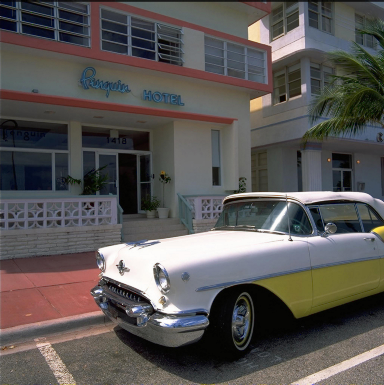

In [ ]:
img_car = cv2.imread('/content/car1.png')
print(img_car.shape)
cv2_imshow(img_car)

In [ ]:
img2 = seams_insertion(img_car, 100)

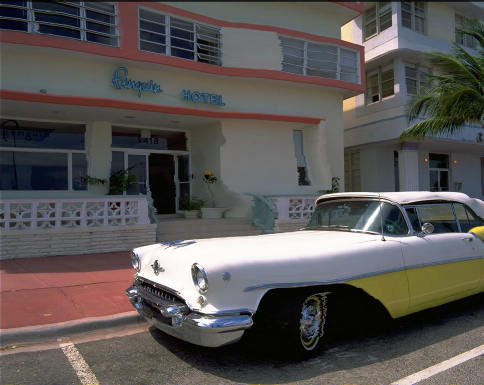

(385, 484, 3)


In [ ]:
cv2_imshow(img2)
print(img2.shape)

# Forward 2

In [ ]:
!pip install scikit-image==0.14.3

In [ ]:
from skimage import io, transform, util
from skimage import filters, color

def forward_energy(img, flag=False):
    height = img.shape[0]
    width = img.shape[1]
    
    I = color.rgb2gray(img)
    energy = np.zeros((height, width))
    m = np.zeros((height, width))
    
    for i in range(1, height):
        for j in range(width):
            up = i-1
            down = i+1
            left = j-1 
            right = j+1
    
            mU = m[up,j]
            mL = m[up,left]
            mR = m[up,right]
                
            cU = np.abs(I[i,right] - I[i,left])
            cL = np.abs(I[up,j] - I[i,left]) + cU
            cR = np.abs(I[up,j] - I[i,right]) + cU
            
            cULR = np.array([cU, cL, cR])
            mULR = np.array([mU, mL, mR]) + cULR
            
            argmin = np.argmin(mULR)
            m[i,j] = mULR[argmin]
            energy[i,j] = cULR[argmin]
            
    return energy

In [ ]:
def seam_carve(img, f, n):
    """
    Helper function to recalculate the energy map after each seam removal
    
    :param img: image to be carved
    :param f: energy map function
    :param n: number of seams to remove
    """
    for i in range(n):
        eimg = f(img)
        img = transform.seam_carve(img, eimg, 'vertical', 1)
    return img, eimg

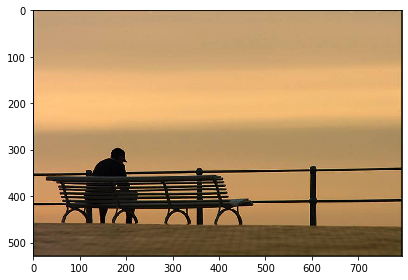

In [ ]:
img = io.imread('/content/bench2.png')
io.imshow(img)

In [ ]:
img, eimg = seam_carve(img, forward_energy, 200)

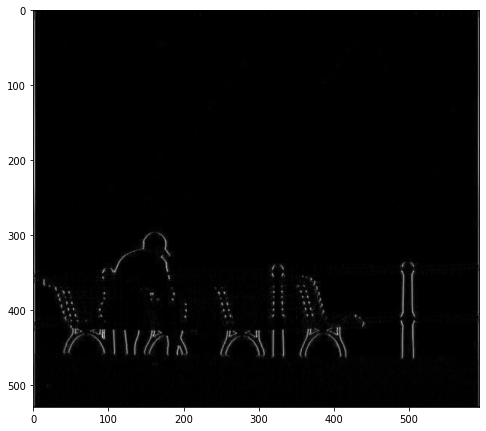

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(eimg, cmap='gray')

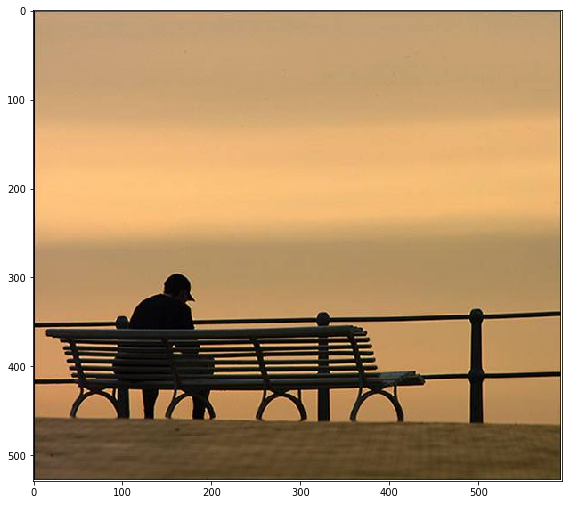

In [ ]:
plt.figure(figsize=(8, 8))
io.imshow(img)

# Export progress to video

In [ ]:
def export_video(img_arr, w, h):
  out = cv2.VideoWriter('video7.avi', 0, 20, (w, h))
  
  for i in range(len(img_arr)):
      out.write(img_arr[i])
  out.release()

# Image christmas

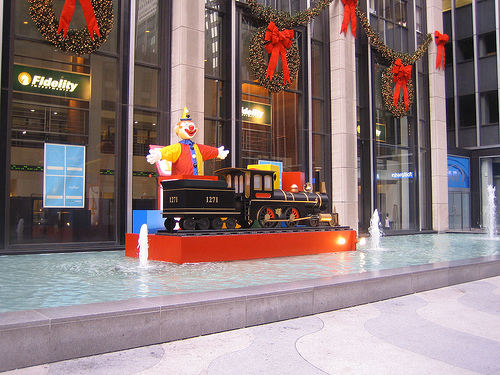

In [ ]:
img = cv2.imread('/content/christmas_original.png')
cv2_imshow(img)

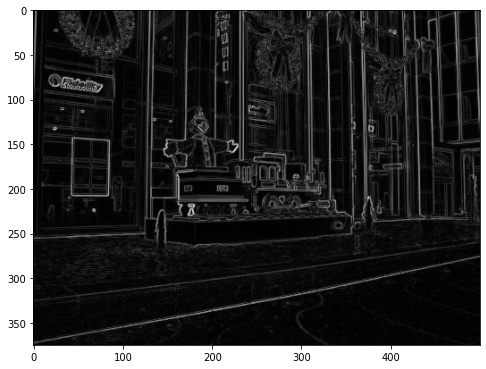

In [ ]:
energy_img = calculate_energy(img)
plt.figure(figsize=(8, 8))
plt.imshow(energy_img, cmap='gray')

In [ ]:
M, backtrack = minimum_seam(img)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [ ]:
M.astype(int)

array([[  312,   164,  4326, ...,  2974,  3800,  1116],
       [  372,   202,  4652, ...,  3894,  5010,  2256],
       [  382,   388,  4930, ...,  4860,  6264,  3594],
       ...,
       [68476, 68992, 69844, ..., 84812, 84700, 84822],
       [71086, 70606, 70450, ..., 84470, 84940, 84892],
       [70774, 70692, 70658, ..., 84428, 84620, 85060]])

In [ ]:
print(np.argmin(M[-1]))
print(np.min(M[-1]))

9
68412.0


In [ ]:
img_result, img_arr = crop_c(img, 0.8, 'bw')

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

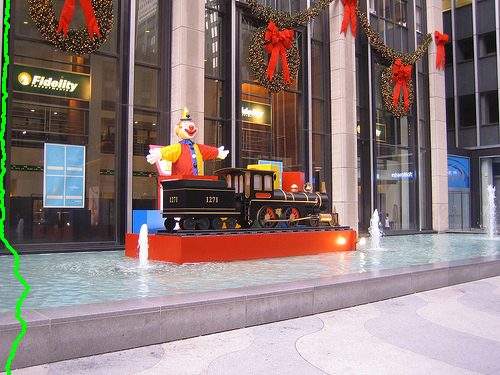

In [ ]:
cv2_imshow(img_arr[1])

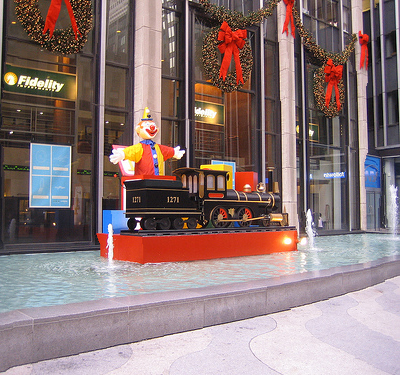

In [ ]:
cv2_imshow(img_result)

In [ ]:
img_return, img_arr = crop_c(img, 0.8, 'fw')

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app
100%|██████████| 100/100 [11:51<00:00,  7.12s/it]


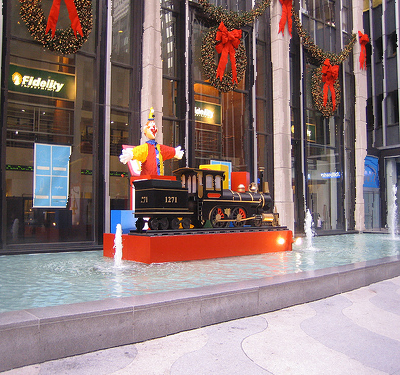

In [ ]:
cv2_imshow(img_return)

# Horizontal

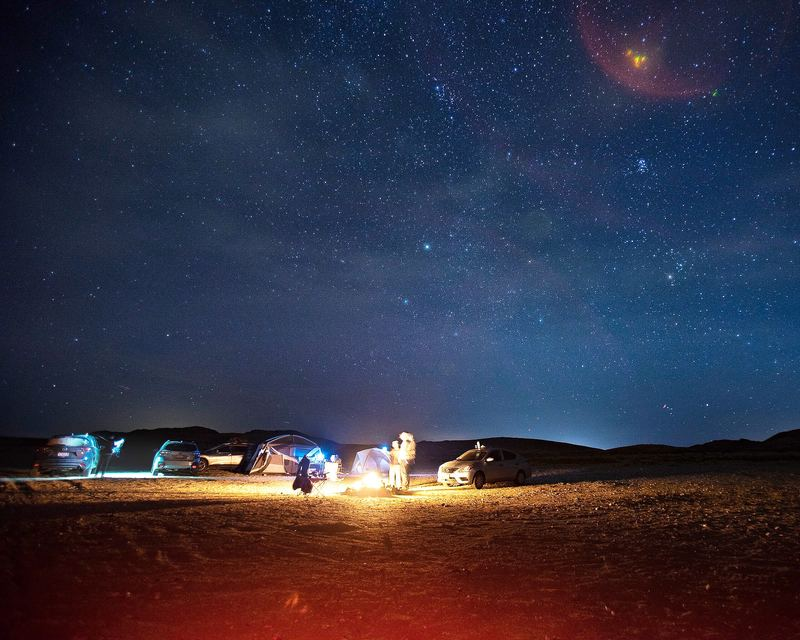

In [ ]:
sky_image = cv2.imread('/content/brent-cox-455716-unsplash.jpg')
cv2_imshow(sky_image)

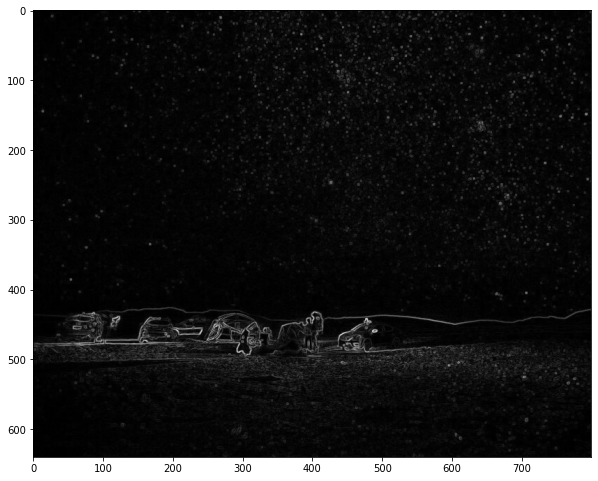

In [ ]:
sky_energy = calculate_energy(sky_image)
plt.figure(figsize=(10, 10))
plt.imshow(sky_energy, cmap='gray')

In [ ]:
sky_result, sky_arr = crop_r(sky_image, 0.5)

  0%|          | 0/320 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

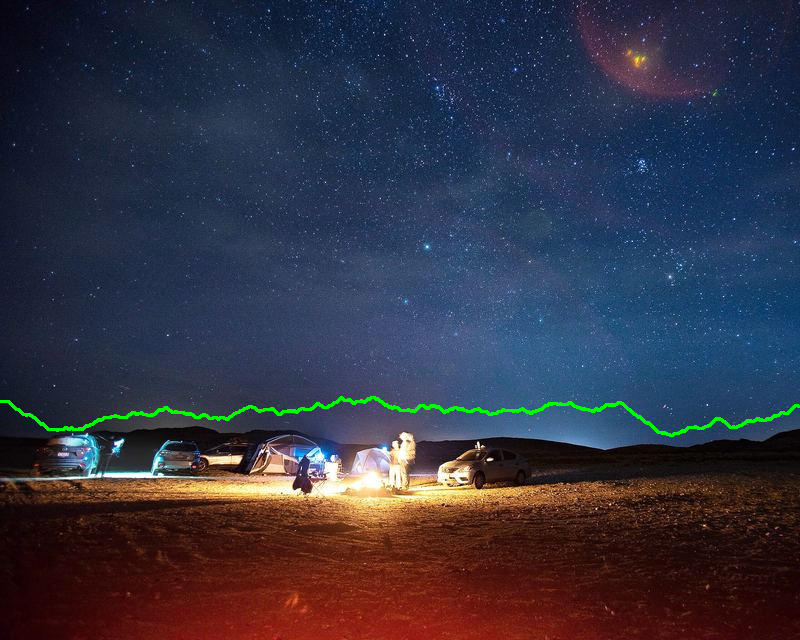

In [ ]:
cv2_imshow(np.rot90(sky_arr[1], 3, (0,1)))

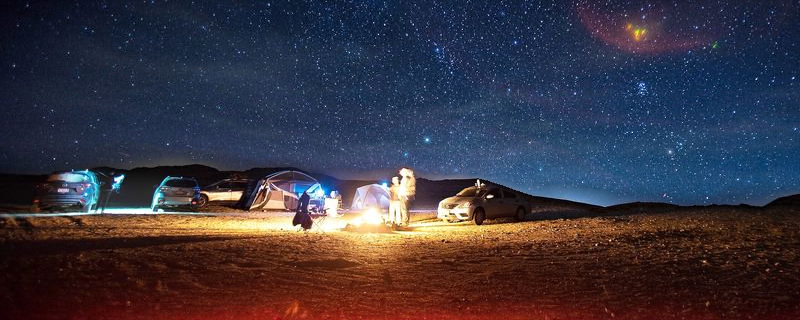

In [ ]:
cv2_imshow(sky_result)

In [ ]:
h, w, _ = sky_image.shape
export_video(sky_arr, w, h)

# Rain

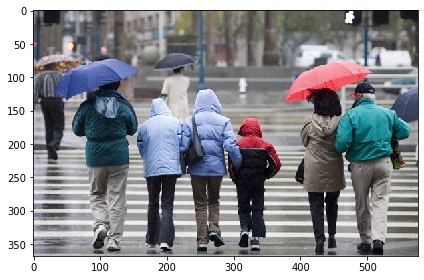

In [ ]:
img_rain = io.imread('/content/rain.png')
io.imshow(img_rain)

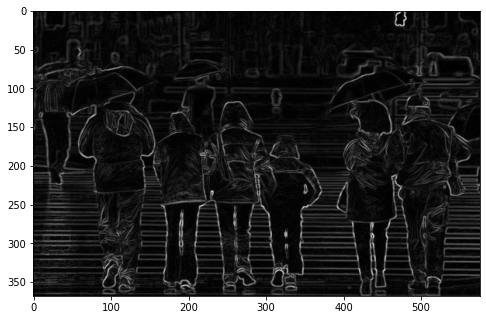

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(calculate_energy(img_rain), cmap='gray')

In [ ]:
M, backtrack = minimum_seam(img_rain)

In [ ]:
M.astype(int)

array([[   756,    918,    162, ...,     90,    108,    126],
       [  1578,   1146,    426, ...,     90,    126,    144],
       [  1968,   1356,    618, ...,    126,    180,    198],
       ...,
       [177356, 177320, 177536, ..., 140514, 142056, 142620],
       [177572, 177374, 177392, ..., 138698, 141390, 142902],
       [177824, 177662, 177626, ..., 138180, 139616, 142326]])

In [ ]:
print(np.argmin(M[-1]))
print(np.min(M[-1]))

457
96890.0


In [ ]:
rain_result, rain_arr = crop_c(img_rain, 0.7, 'bw')

  0%|          | 0/173 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

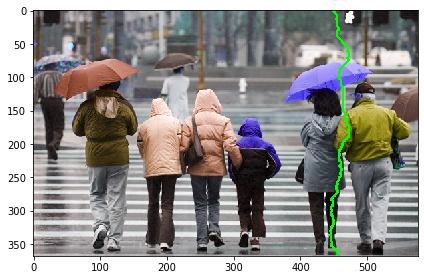

In [ ]:
io.imshow(rain_arr[1])

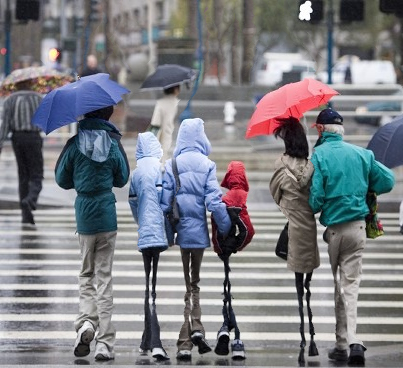

In [ ]:
cv2_imshow(rain_result)

In [ ]:
rain_fw, eimg_fw = seam_carve(img_rain, forward_energy, 173)

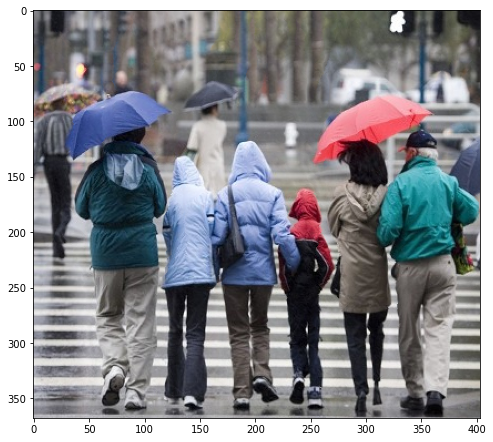

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(rain_fw)

# Image plier

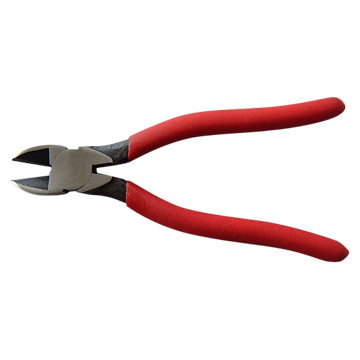

In [ ]:
img_plier = cv2.imread('/content/plier.jpg')
cv2_imshow(img_plier)

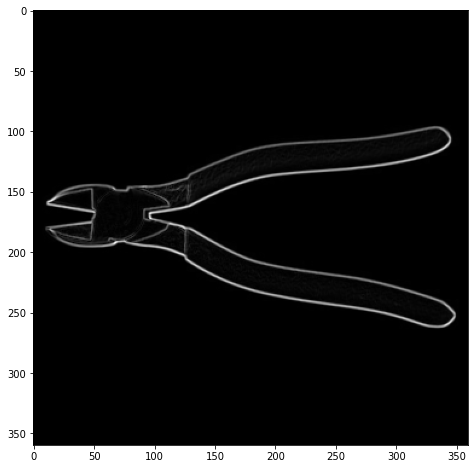

In [ ]:
energy = calculate_energy(img_plier)
plt.figure(figsize=(8,8))
plt.imshow(energy, cmap='gray')

In [ ]:
plier_return, plier_arr = crop_c(img_plier, 0.5, 'bw')

  0%|          | 0/180 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

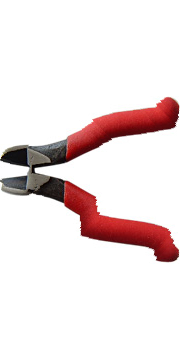

In [ ]:
cv2_imshow(plier_return)

In [ ]:
plier_img_fw, plier_arr_fw = crop_c(img_plier, 0.5, 'fw')

  0%|          | 0/180 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app
100%|██████████| 180/180 [11:09<00:00,  3.72s/it]


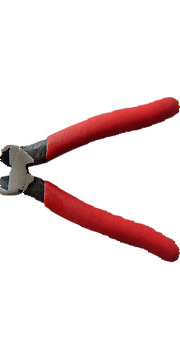

In [ ]:
cv2_imshow(plier_img_fw)

# Forward seam carving

In [ ]:
def D(p1, p2):
  d = np.sum((p1 - p2) ** 2)
  return d
  # d = (p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2 + (p1[2] - p2[2]) ** 2
  # return np.sqrt(d)

In [ ]:

def calculate_cost(img):
  h, w, _ = img.shape
  cL = np.zeros((h, w), dtype=np.uint8)
  cU = np.zeros((h, w), dtype=np.uint8)
  cR = np.zeros((h, w), dtype=np.uint8)

  for j in range(1, w - 1):
    cU[0, j] = D(img[0, j - 1], img[0, j+1])
  
  for i in range(1, h):
    d = D(img[i, 0], img[i,1])
    # left edge
    cL[i, 0] = d + D(img[i-1, 0], img[i, 0])
    cU[i, 0] = d
    cR[i, 0] = d + D(img[i-1, 0], img[i, 1])

    # right edge
    dr = D(img[i, w-1], img[i,w-2])
    cL[i, w-1] = dr + D(img[i-1, w-1], img[i, w-1])
    cU[i, w-1] = dr
    cR[i, w-1] = dr + (img[i-1, w-1], img[i, w-2])

  for i in range(1, h):
    for j in range(1, w - 1):
      d = D(img[i, j-1], img[i, j+1])
      cL[i, j] = d + D(img[i-1, j], img[i, j-1])
      cU[i, j] = d
      cR[i, j] = d + D(img[i-1, j], img[i, j+1])
  
  return cL, cU, cR

In [ ]:
def cal_seam_forward(img):

  h, w, _ = img.shape
  M = np.zeros((h, w), dtype=np.int16)
  backtrack = np.zeros((h, w), dtype=np.int16)
  cL, cU, cR = calculate_cost(img)
  M[0, :] = cU[0, :]
  for i in range(1, h):
    for j in range(0, w):
      # Handle the left edge of the image, to ensure we don't index -1
      if j == 0:
        mU = M[i-1, j] + cU[i, j]
        mR = M[i-1, j+1] + cR[i, j]
        idx = np.argmin([mU, mR])

        backtrack[i, j] = idx + j
        M[i, j] = np.min([mU, mR])
      elif j == w-1:
        mL = M[i-1, j-1] + cL[i,j]
        mU = M[i-1, j] + cU[i, j]
        
        idx = np.argmin([mL, mU])

        backtrack[i, j] = idx + j-1
        M[i, j] = np.min([mL, mU])
      else:
        mL = M[i-1, j-1] + cL[i,j]
        mU = M[i-1, j] + cU[i, j]
        mR = M[i-1, j+1] + cR[i, j]
        idx = np.argmin([mL, mU, mR])
        backtrack[i, j] = idx + j - 1
        M[i, j] = np.min([mL, mU, mR])

  return M, backtrack

In [ ]:
import numpy  as np
import cv2
from skimage import filters, color
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

In [ ]:
img = cv2.imread('/content/car1.png')

In [ ]:
h, w, _ = img.shape
I = color.rgb2gray(img)
    
energy = np.zeros((h, w))
m = np.zeros((h, w))

U = np.roll(I, 1, axis=0)
L = np.roll(I, 1, axis=1)
R = np.roll(I, -1, axis=1)

eimg = filters.sobel(img)

In [ ]:
energy = forward_energy(img)

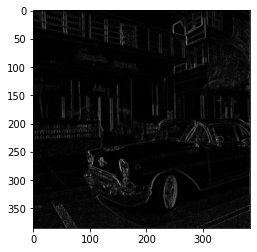

In [ ]:
plt.imshow(energy, cmap='gray')

In [ ]:
energy[-1, :]

In [ ]:
eimg.shape

(385, 384, 3)

In [ ]:
img.shape

(385, 384, 3)

In [ ]:
x = np.array([[1,2,3,4,5],
     [6,7,8,9,10],
     [1,3,5,7,9]])

u = np.roll(x, 1, axis= 0)
l = np.roll(x, 1, axis = 1)
r = np.roll(x, -1, axis = 1)

In [ ]:
u

array([[ 1,  3,  5,  7,  9],
       [ 1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10]])

In [ ]:
l

array([[ 5,  1,  2,  3,  4],
       [10,  6,  7,  8,  9],
       [ 9,  1,  3,  5,  7]])

In [ ]:
r

array([[ 2,  3,  4,  5,  1],
       [ 7,  8,  9, 10,  6],
       [ 3,  5,  7,  9,  1]])